<a href="https://colab.research.google.com/github/tyler-skaggs/Numerical-Analysis/blob/main/PINNs_2DHeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.stats import qmc
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import warnings
import time

warnings.filterwarnings('ignore')
np.random.seed(1324)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using CUDA


In [318]:
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # parameters
        self.depth = len(layers)-1

        # set up layer order dict
        self.activation = torch.nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        # deploy Layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

# The physics-guided nerual network
class PhysicsInformedNN():
    def __init__(self, X_IC_init, X_BC_init, X_f, layers, alpha = 1/3):
        # data
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.y_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 2:3], requires_grad=True).float().to(device)

        self.x_IC = torch.tensor(X_IC_init[:, 0:1], requires_grad=True).float().to(device)
        self.y_IC = torch.tensor(X_IC_init[:, 1:2], requires_grad=True).float().to(device)
        self.t_IC = torch.tensor(X_IC_init[:, 2:3], requires_grad=True).float().to(device)

        self.x_BC = torch.tensor(X_BC_init[:, 0:1], requires_grad=True).float().to(device)
        self.y_BC = torch.tensor(X_BC_init[:, 1:2], requires_grad=True).float().to(device)
        self.t_BC = torch.tensor(X_BC_init[:, 2:3], requires_grad=True).float().to(device)

        self.u_IC = torch.tensor(X_IC_init[:, 3:4]).float().to(device)
        self.u_BC = torch.tensor(X_BC_init[:, 3:4]).float().to(device)

        self.layers = layers
        self.alpha = alpha

        # Deep Neural Networks
        self.dnn = DNN(layers).to(device)

        # optimizer: using the same settings
        self.optimizer = torch.optim.Adam(self.dnn.parameters())

    def net_u(self, x, y, t):
        u = self.dnn(torch.cat([x, y, t], dim=1))
        return u

    def net_f(self, x, y, t):
        """ The pytorch autograd for calculating residual """
        u = self.net_u(x, y, t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        u_y = torch.autograd.grad(
            u, y,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_yy = torch.autograd.grad(
            u_y, y,
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_t - 1/9 * (u_xx + u_yy)
        return f

    def loss_func(self):
        omega = [1, 5, 5]
        u_BC_pred = self.net_u(self.x_BC, self.y_BC, self.t_BC)
        u_IC_pred = self.net_u(self.x_IC, self.y_IC, self.t_IC)
        f_pred = self.net_f(self.x_f, self.y_f, self.t_f)

        loss_BC = torch.nn.MSELoss()(u_BC_pred, self.u_BC)
        loss_IC = torch.nn.MSELoss()(u_IC_pred, self.u_IC)
        loss_PDE = torch.mean(f_pred ** 2)

        loss = omega[0]*loss_PDE + omega[1] * loss_IC + omega[2] * loss_BC

        return loss, loss_PDE, loss_IC, loss_BC

    def train(self, epochs):
        loss_hist = np.array([0,0,0,0])
        for epoch in range(epochs):
            # Zero Gradients
            self.optimizer.zero_grad()

            # Compute Loss and Gradients
            loss, loss_PDE, loss_IC, loss_BC = self.loss_func()
            loss.backward()

            # Adjust Learning Weights
            self.optimizer.step()

            if epoch % 100 == 0:
                print(
                    'Epoch %d | Loss: %.5e, L_PDE: %.5e, L_IC: %.5e, L_BC: %.5e' % (
                        epoch,
                        loss.item(),
                        loss_PDE.item(),
                        loss_IC.item(),
                        loss_BC.item()
                    )
                )
            loss_hist = np.vstack((loss_hist, np.array(([
                loss.detach().cpu().numpy(),
                loss_PDE.detach().cpu().numpy(),
                loss_IC.detach().cpu().numpy(),
                loss_BC.detach().cpu().numpy()
            ]))))

        return np.delete(loss_hist, (0), axis=0)

    def predict(self, X):
        x = torch.tensor(X[:, 0:1]).float().to(device)
        y = torch.tensor(X[:, 1:2]).float().to(device)
        t = torch.tensor(X[:, 2:3]).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, y, t)
        u = u.detach().cpu().numpy()

        return u

In [350]:
def init(x, y):
  if y <= 1:
    return 50
  else:
    return 0

def boundary(x,y):
  return 0

Nx = 1000
Nt = 500
N_f = 10000

layers = [3, 50, 50, 50, 50, 1]

sampler = qmc.LatinHypercube(d = 2)

x = sampler.random(Nx)
x = qmc.scale(x, [0,0], [2,2])
temp = np.zeros(Nx)
for i in range(Nx):
  temp[i] = init(x[i,0], x[i,1])

X_IC = np.vstack((x[:, 0], x[:, 1], np.zeros(Nx), temp)).T

# X = 0 Boundary
t = np.random.random_sample(Nt)
xval = 0 * np.ones(Nt)
yval = np.random.random_sample(Nt) * 2
X_BC = np.vstack((xval, yval, t, np.zeros(Nt))).T

# X = 2 Boundary
t = np.random.random_sample(Nt)
xval = 2 * np.ones(Nt)
yval = np.random.random_sample(Nt) * 2
X_BC = np.vstack((X_BC, np.vstack((xval, yval, t, np.zeros(Nt))).T))


# Y = 0 Boundary
t = np.random.random_sample(Nt)
xval = np.random.random_sample(Nt) * 2
yval = 0 * np.ones(Nt)
X_BC = np.vstack((X_BC, np.vstack((xval, yval, t, np.zeros(Nt))).T))

# Y = 2 Boundary
t = np.random.random_sample(Nt)
xval = np.random.random_sample(Nt) * 2
yval = 2 * np.ones(Nt)
X_BC = np.vstack((X_BC, np.vstack((xval, yval, t, np.zeros(Nt))).T))

# Random N_f data to train on
sampler = qmc.LatinHypercube(d = 3)

X_training = sampler.random(N_f)
X_training = qmc.scale(X_training, [0, 0, 0], [2, 2, 1])

x = X_training[:, 0]
y = X_training[:, 1]
t = X_training[:, 2]

X_training = np.vstack((X_training, X_IC[:, 0:3], X_BC[:, 0:3]))

Training

In [351]:
# training
epochs = 30000
start_time = time.time()

model = PhysicsInformedNN(X_IC, X_BC, X_training, layers)
loss_history = model.train(epochs)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Executation Time: {elapsed_time:.6f} seconds")

Epoch 0 | Loss: 6.27184e+03, L_PDE: 2.25801e-03, L_IC: 1.25436e+03, L_BC: 4.16205e-03
Epoch 100 | Loss: 4.73341e+03, L_PDE: 4.39986e+00, L_IC: 9.04211e+02, L_BC: 4.15914e+01
Epoch 200 | Loss: 3.83103e+03, L_PDE: 2.73816e+01, L_IC: 6.83102e+02, L_BC: 7.76280e+01
Epoch 300 | Loss: 2.98292e+03, L_PDE: 1.30717e+02, L_IC: 5.36541e+02, L_BC: 3.39001e+01
Epoch 400 | Loss: 2.10722e+03, L_PDE: 6.27273e+01, L_IC: 3.85719e+02, L_BC: 2.31808e+01
Epoch 500 | Loss: 1.54721e+03, L_PDE: 6.12173e+01, L_IC: 2.73794e+02, L_BC: 2.34045e+01
Epoch 600 | Loss: 1.12044e+03, L_PDE: 5.60246e+01, L_IC: 1.93223e+02, L_BC: 1.96605e+01
Epoch 700 | Loss: 7.87572e+02, L_PDE: 3.67561e+01, L_IC: 1.34553e+02, L_BC: 1.56101e+01
Epoch 800 | Loss: 5.66064e+02, L_PDE: 3.29840e+01, L_IC: 9.22859e+01, L_BC: 1.43301e+01
Epoch 900 | Loss: 4.16828e+02, L_PDE: 2.93103e+01, L_IC: 6.44699e+01, L_BC: 1.30336e+01
Epoch 1000 | Loss: 3.20266e+02, L_PDE: 2.81178e+01, L_IC: 4.49980e+01, L_BC: 1.34316e+01
Epoch 1100 | Loss: 2.63801e+02, L

Plotting

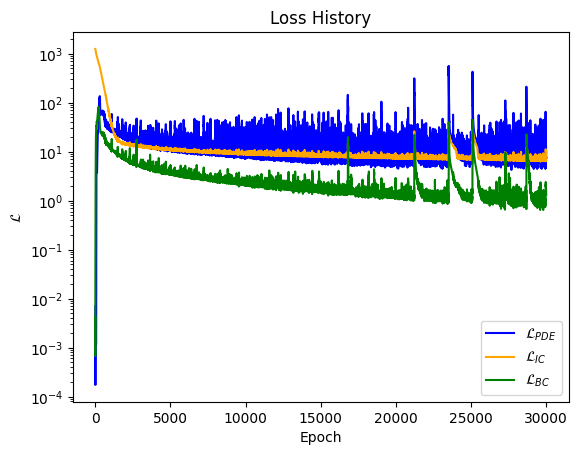

In [352]:
plt.plot(range(1,epochs+1), loss_history[:,1], color='blue', label=r"$\mathcal{L}_{PDE}$")
plt.plot(range(1,epochs+1), loss_history[:,2], color='orange', label=r"$\mathcal{L}_{IC}$")
plt.plot(range(1,epochs+1), loss_history[:,3], color='green', label=r"$\mathcal{L}_{BC}$")
plt.ylabel(r"$\mathcal{L}$")
plt.xlabel("Epoch")
plt.legend()
plt.yscale('log')
plt.title("Loss History")
plt.show()

x_pred = np.linspace(0,2, 21)
y_pred = np.linspace(0,2, 21)
t_pred = np.array([np.linspace(0, 1, 11)]).T
X, Y, T = np.meshgrid(x_pred, y_pred, t_pred)

X_pred = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))

u_pred = model.predict(X_pred)
U = griddata(X_pred, u_pred.flatten(), (X, Y, T))

In [342]:
def analytic_Sol(x,y,t):
  sum = 0
  M = 25
  N = 25
  for m in range(1,M+1):
    for n in range(1,N+1):
      sum += ((1 + (-1)**(m%2 + 1))*(1 - np.cos(n*np.pi/2)))/(m*n) * np.sin(m*np.pi/2*x) * np.sin(n*np.pi/2*y) * np.exp(-np.pi**2 * (m**2 + n**2) * t / 36)

  return 200 / np.pi**2 * sum

Exact = np.copy(X)
for i in range(len(X[:, 0, 0])):
  for j in range(len(X[0, :, 0])):
    for k in range(len(X[0, 0, :])):
      Exact[i, j, k] = analytic_Sol(x_pred[i], y_pred[j], t_pred[k])


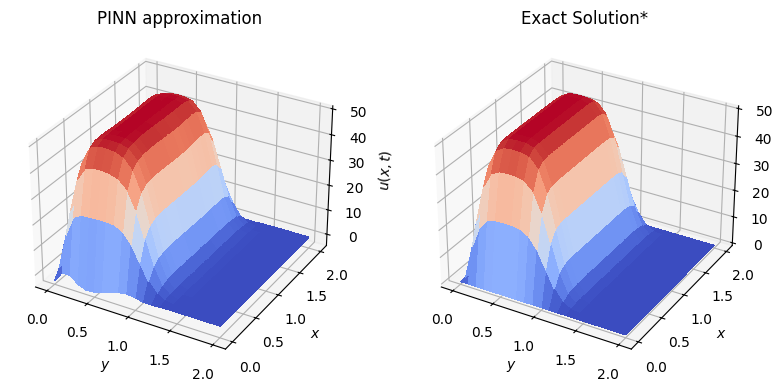

In [354]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
T = -1
surf = ax.plot_surface(Y[:,:,T], X[:,:,T], U[:, :, T], rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel(r"$y$")
ax.set_ylabel(r"$x$")
ax.set_zlabel(r"$u(x,t)$")
ax.set_title(r"PINN approximation")

# ==============
# Second subplot
# ==============
# set up the Axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo


surf = ax.plot_surface(X[:,:,T], Y[:,:,T], Exact[:, :, T], rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel(r"$y$")
ax.set_ylabel(r"$x$")
ax.set_zlabel(r"$u(x,t)$")
ax.set_title(r"Exact Solution*")
plt.show()
